In [1]:
DEBUG = False

In [2]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-rc7ca_ng
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-rc7ca_ng
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-cp37-none-any.whl size=3881 sha256=46d1667a734b6fa36382a71c5408d5eecd9b4e212e0e53cbe0a300f446213b93
  Stored in directory: /tmp/pip-ephem-wheel-cache-i1vd2kwc/wheels/b7/24/83/d30234cc013cff538805b14df916e79091f7cf9ee2c5bf3a64
Successfully built warmup-scheduler


In [4]:
import os
import sys
sys.path = [
    '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
] + sys.path

In [5]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import timm
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm



# Config

In [6]:
data_dir = '../input/prostate-cancer-grade-assessment'
data_dir = '/media/frank/ext_drive/data/kaggle_panda/'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')

kernel_type = 'panda-b1-gem-mixnet-l-train-fold-0-v2'

enet_type = 'efficientnet-b1'
fold = 0
tile_size = 256
image_size = 256
n_tiles = 36
batch_size = 2
num_workers = 4
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 30 #1 if DEBUG else 30
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

/media/frank/ext_drive/data/kaggle_panda/train_images


# Create Folds

In [7]:
skf = StratifiedKFold(5, shuffle=True, random_state = 42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,4
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,4


# Model

In [8]:
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

    
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = backbone
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

# Dataset

In [9]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)


# Augmentations

In [10]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

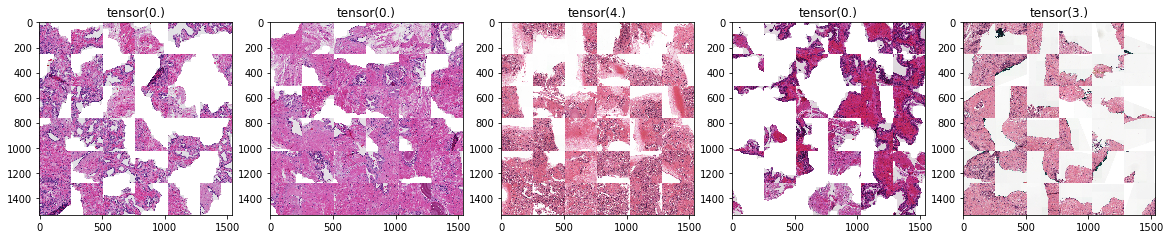

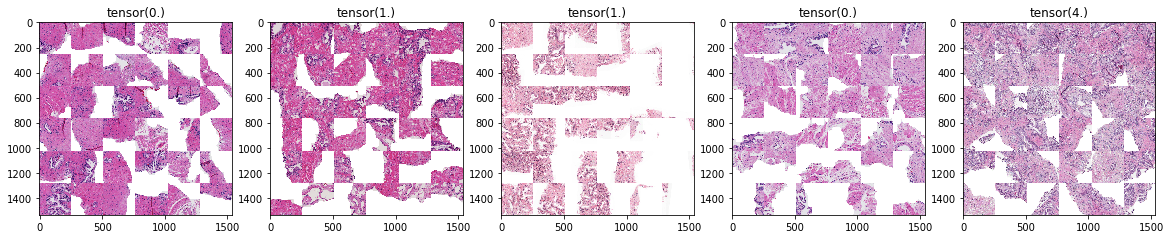

In [11]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))


# Loss

In [12]:
criterion = nn.BCEWithLogitsLoss()

# Train & Val

In [13]:
def train_epoch(loader, optimizer):
    
    model.train()
    scaler = torch.cuda.amp.GradScaler()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        # data, target = data.to(device=device).half().float(), target.to(device)
        data, target = data.to(device=device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            logits = model(data)
            loss = loss_func(logits, target)
        
        # loss.backward()
        scaler.scale(loss).backward()
        
        # optimizer.step()
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []
    
    scaler = torch.cuda.amp.GradScaler()

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            # data, target = data.to(device=device).half().float(), target.to(device)
            data, target = data.to(device=device), target.to(device)
            
            with torch.cuda.amp.autocast():
                logits = model(data)
                loss = criterion(logits, target)
                pred = logits.sigmoid().sum(1).detach().round()
                
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

    

# Create Dataloader & Model & Optimizer

In [14]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)


model = timm.create_model('mixnet_l', pretrained=True)

enet_type = model
model = enetv2(enet_type, out_dim=out_dim)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(
    optimizer,
    multiplier=warmup_factor,
    total_epoch=warmup_epo,
    after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

8492 2124


In [15]:
model.avg_pool = GeM()

# model.half().float()
# for layer in model.modules():
#     if isinstance(layer, nn.BatchNorm2d):
#         layer.float()
        
model = model.to(device)

model

enetv2(
  (enet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv_pw): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (1): Sequential(
        (0): InvertedResidual(
          (conv_pw): MixedConv2d(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): Conv2d(16, 

# Run Training

In [ ]:
%%time

qwk_max = 0.
best_file = f'{kernel_type}_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk
        
    torch.save(model.state_dict(), os.path.join(f'{kernel_type}_fold{fold}_epoch_{epoch}.pth'))

torch.save(model.state_dict(), os.path.join(f'{kernel_type}_final_fold{fold}.pth'))

Mon Jun 29 21:36:53 2020 Epoch: 1


/home/frank/miniconda3/envs/py37/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/frank/miniconda3/envs/py37/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are un

/home/frank/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



qwk 0.7150170983070281 qwk_k 0.6926000386374518 qwk_r 0.6426043975871076
Mon Jun 29 22:11:22 2020 Epoch 1, lr: 0.0000300, train loss: 0.43593, val loss: 0.32515, acc: 33.28625, qwk: 0.71502
score2 (0.000000 --> 0.715017).  Saving model ...
Mon Jun 29 22:11:22 2020 Epoch: 2



qwk 0.810173248953469 qwk_k 0.7934308676876998 qwk_r 0.7549497682502585
Mon Jun 29 22:45:50 2020 Epoch 2, lr: 0.0003000, train loss: 0.35693, val loss: 0.28214, acc: 52.35405, qwk: 0.81017
score2 (0.715017 --> 0.810173).  Saving model ...
Mon Jun 29 22:45:50 2020 Epoch: 3



qwk 0.837933500667362 qwk_k 0.8396160482483175 qwk_r 0.7914994883957793
Mon Jun 29 23:20:18 2020 Epoch 3, lr: 0.0000300, train loss: 0.24704, val loss: 0.24585, acc: 59.93409, qwk: 0.83793
score2 (0.810173 --> 0.837934).  Saving model ...
Mon Jun 29 23:20:18 2020 Epoch: 4



qwk 0.8448576526268113 qwk_k 0.8567141482194418 qwk_r 0.7880765988927361
Mon Jun 29 23:56:20 2020 Epoch 4, lr: 0.0002965, train loss: 0.28512, val loss: 0.25661, acc: 56.35593, qwk: 0.84486
score2 (0.837934 --> 0.844858).  Saving model ...
Mon Jun 29 23:56:20 2020 Epoch: 5



qwk 0.8044435973360746 qwk_k 0.819203280970107 qwk_r 0.7494536283402854
Tue Jun 30 00:32:46 2020 Epoch 5, lr: 0.0002921, train loss: 0.26290, val loss: 0.28559, acc: 61.53484, qwk: 0.80444
Tue Jun 30 00:32:47 2020 Epoch: 6



qwk 0.839774127126023 qwk_k 0.8697617538850543 qwk_r 0.7729550442162044
Tue Jun 30 01:09:17 2020 Epoch 6, lr: 0.0002861, train loss: 0.25004, val loss: 0.25737, acc: 59.46328, qwk: 0.83977
Tue Jun 30 01:09:17 2020 Epoch: 7



qwk 0.8224091902492621 qwk_k 0.819781983981261 qwk_r 0.7746780252644403
Tue Jun 30 01:45:46 2020 Epoch 7, lr: 0.0002785, train loss: 0.23646, val loss: 0.31816, acc: 58.85122, qwk: 0.82241
Tue Jun 30 01:45:46 2020 Epoch: 8



qwk 0.8339220301448981 qwk_k 0.847248988437173 qwk_r 0.7680872437669791
Tue Jun 30 02:22:17 2020 Epoch 8, lr: 0.0002694, train loss: 0.22520, val loss: 0.35830, acc: 54.99058, qwk: 0.83392
Tue Jun 30 02:22:17 2020 Epoch: 9



qwk 0.8414947280561523 qwk_k 0.8679117723876587 qwk_r 0.7705632975545333
Tue Jun 30 02:58:48 2020 Epoch 9, lr: 0.0002589, train loss: 0.21783, val loss: 0.29046, acc: 57.48588, qwk: 0.84149
Tue Jun 30 02:58:48 2020 Epoch: 10



qwk 0.8371752187330628 qwk_k 0.8459726622499889 qwk_r 0.7770086476463729
Tue Jun 30 03:35:20 2020 Epoch 10, lr: 0.0002471, train loss: 0.21066, val loss: 0.29789, acc: 54.33145, qwk: 0.83718
Tue Jun 30 03:35:20 2020 Epoch: 11



qwk 0.8523444592542617 qwk_k 0.8804465052214233 qwk_r 0.7858910289010392
Tue Jun 30 04:11:53 2020 Epoch 11, lr: 0.0002342, train loss: 0.20139, val loss: 0.30571, acc: 58.99247, qwk: 0.85234
score2 (0.844858 --> 0.852344).  Saving model ...
Tue Jun 30 04:11:53 2020 Epoch: 12



qwk 0.8647957741979871 qwk_k 0.8728445225996362 qwk_r 0.8219244195526413
Tue Jun 30 04:48:21 2020 Epoch 12, lr: 0.0002203, train loss: 0.19086, val loss: 0.24354, acc: 63.51224, qwk: 0.86480
score2 (0.852344 --> 0.864796).  Saving model ...
Tue Jun 30 04:48:21 2020 Epoch: 13



qwk 0.8512852054591821 qwk_k 0.8775699021417844 qwk_r 0.7827847015555758
Tue Jun 30 05:24:51 2020 Epoch 13, lr: 0.0002055, train loss: 0.18262, val loss: 0.24201, acc: 60.02825, qwk: 0.85129
Tue Jun 30 05:24:52 2020 Epoch: 14



qwk 0.854587204487712 qwk_k 0.8633904678823334 qwk_r 0.8047052944943979
Tue Jun 30 06:01:20 2020 Epoch 14, lr: 0.0001901, train loss: 0.17470, val loss: 0.27595, acc: 61.34652, qwk: 0.85459
Tue Jun 30 06:01:21 2020 Epoch: 15



qwk 0.8540456735062504 qwk_k 0.8783711236919605 qwk_r 0.7941438283964344
Tue Jun 30 06:38:06 2020 Epoch 15, lr: 0.0001743, train loss: 0.16707, val loss: 0.26304, acc: 62.99435, qwk: 0.85405
Tue Jun 30 06:38:06 2020 Epoch: 16



qwk 0.8476163328064129 qwk_k 0.8687875441207605 qwk_r 0.7886249669821377
Tue Jun 30 07:15:01 2020 Epoch 16, lr: 0.0001581, train loss: 0.15882, val loss: 0.27763, acc: 63.41808, qwk: 0.84762
Tue Jun 30 07:15:02 2020 Epoch: 17



qwk 0.8680655032794741 qwk_k 0.8772723814492376 qwk_r 0.8212947514052196
Tue Jun 30 07:52:06 2020 Epoch 17, lr: 0.0001419, train loss: 0.14977, val loss: 0.23941, acc: 64.26554, qwk: 0.86807
score2 (0.864796 --> 0.868066).  Saving model ...
Tue Jun 30 07:52:06 2020 Epoch: 18



qwk 0.8598868418900245 qwk_k 0.8794975977707407 qwk_r 0.804126343930651
Tue Jun 30 08:28:53 2020 Epoch 18, lr: 0.0001257, train loss: 0.14297, val loss: 0.24679, acc: 64.03013, qwk: 0.85989
Tue Jun 30 08:28:53 2020 Epoch: 19



qwk 0.8636312824371843 qwk_k 0.8904243123616266 qwk_r 0.8076027875000288
Tue Jun 30 09:05:26 2020 Epoch 19, lr: 0.0001099, train loss: 0.13262, val loss: 0.26315, acc: 66.38418, qwk: 0.86363
Tue Jun 30 09:05:26 2020 Epoch: 20
